# Perspective Shift Identification

### Goal: 
Use ML to identify perspective shift in movement of distribution centers

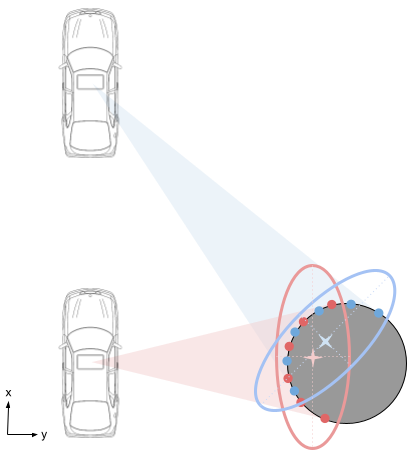

### Assumptions:
Gross rotation and translation have already been estimated by previous scan matching iterations

### Network structure:
Inputs: 
xyz of 25 points randomly sampled from each distribution

Output:
Correction factor translation between the two centers



### Training data generation

(starting with toy example)

1- generate grid of simple shapes in Inventor

2- Rotate randomly, translate randomly and simulate lidar scan of shapes at 2 points in time using MatLab script

3- Sample N points from each object and save to file. Also store information on rotation and translation to seperate file

4- import data here and augment again by duplicating and scaling examples arbitrarily

## TODO

Get tf.data() pipeline working

Scale allowable error threshold between DNN and D2D by radial disatance from origin

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.io as sio
import datetime
# import tensorflow_graphics as tfg
# import tensorflow_graphics.nn.layer.pointnet

#need to have these two lines to work on my ancient 1060 3gb
#  https://stackoverflow.com/questions/43990046/tensorflow-blas-gemm-launch-failed
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

print(tf.__version__) #requires tensorflow 2.3

# %matplotlib inline
# plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
# plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['image.cmap'] = 'gray'
%matplotlib notebook

%load_ext tensorboard

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2
%autosave 180

2.3.0


Autosaving every 180 seconds


In [2]:
#Load data directly from numpy files-- KEEP IN RAM (DO NOT CONVERT TO TF Tensor!!!)
#_________________________________________________________________
#load individual data numpy files
d1_1 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v1_scan1.npy")
d2_1 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v1_scan2.npy")
gt_1 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v1_ground_truth.npy")
# d1_1 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v3_scan1.npy")
# d2_1 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v3_scan2.npy")
# gt_1 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v3_ground_truth.npy")

# d1_1 = np.load("C:/Users/Derm/Desktop/big/pshift/scan1_300k_50_samples.npy")
# d2_1 = np.load("C:/Users/Derm/Desktop/big/pshift/scan2_300k_50_samples.npy")
# gt_1 = np.load("C:/Users/Derm/Desktop/big/pshift/ground_truth_300k_50_samples.npy")
# gt_1 = gt_1*0.1 #scale to match real-world data (vel-> pos)

# d1_2 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v2_scan1.npy")
# d2_2 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v2_scan2.npy")
# gt_2 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v2_ground_truth.npy")
d1_2 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v4_scan1.npy")
d2_2 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v4_scan2.npy")
gt_2 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v4_ground_truth.npy")


d1 = np.append(d1_1, d1_2, axis = 0)
d2 = np.append(d2_1, d2_2, axis = 0)
gt = np.append(gt_1, gt_2, axis = 0)
#_________________________________________________________________

# d1 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v2_scan1.npy")
# d2 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v2_scan2.npy")
# gt = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v2_ground_truth.npy")

# d1 = np.load("C:/Users/Derm/Desktop/big/pshift/scan1_300k_50_samples.npy")
# d2 = np.load("C:/Users/Derm/Desktop/big/pshift/scan2_300k_50_samples.npy")
# gt = np.load("C:/Users/Derm/Desktop/big/pshift/ground_truth_300k_50_samples.npy")
# gt = gt*0.1 #scale to match real-world data (vel-> pos)

#reshape but don't convert to tensor
points_per_sample = 50          #poitns sammpled from each voxel
tsplit = 0.9 #0.95                   #this fraction goes into training

scan1 = np.reshape(d1, [-1, points_per_sample, 3])
scan2 = np.reshape(d2, [-1, points_per_sample, 3])
ntrain = int(tsplit*tf.shape(scan1)[0].numpy())

x_train = np.append(scan1[:ntrain], scan2[:ntrain], axis = 1)
x_test = np.append(scan1[ntrain:], scan2[ntrain:], axis = 1)
print(np.shape(x_train))
# print(np.shape(x_test))

y_train = gt[:ntrain]
y_test = gt[ntrain:]
# print(y_train)
# print(np.shape(y_train))
# print(np.shape(y_test))

#-------------------------------------------------------------------

(1164497, 100, 3)


In [4]:
#train network
from network import Net
# from network import PointNet as Net
# from network import Attention as Net

runLen = 300

def scheduler(epoch, learning_rate):
#     part1 = 2*runLen//3
#     part2 = 5*runLen//6 #net1

    part1 = runLen//3
    part2 = 2*runLen//3 #net2

    if epoch < part1:
        learning_rate = 0.002
        return learning_rate
    if epoch >= part1 and epoch < part2:
        learning_rate = 0.001
        return learning_rate
    if epoch >= part2:
        learning_rate = 0.00025
        return learning_rate

model = Net() #comment out to re-train existing network
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = tf.keras.losses.MeanAbsoluteError()) #was MeanSquaredError()

summary = model.summary()
print(summary)
scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
cp = tf.keras.callbacks.ModelCheckpoint("FordNetCP.kmod", monitor = 'val_loss', save_best_only = True) 

log_dir = "runs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

trace = model.fit(x = x_train, y = y_train, batch_size = 1024, epochs=runLen, verbose=1, 
                  validation_split = 0.2, shuffle=True, callbacks = [cp])

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 3)]          0         
_________________________________________________________________
tf_op_layer_ExpandDims (Tens [(None, 100, 3, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 1, 64)        256       
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 1, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 1, 64)        4160      
_________________________________________________________________
batch_normalization_1 (Batch (None, 100, 1, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 1, 64)       

910/910 [==============================] - 105s 116ms/step - loss: 0.0646 - val_loss: 0.0487
Epoch 34/300
910/910 [==============================] - 102s 113ms/step - loss: 0.0648 - val_loss: 0.0554
Epoch 35/300
910/910 [==============================] - 102s 112ms/step - loss: 0.0640 - val_loss: 0.0440
Epoch 36/300
910/910 [==============================] - 104s 114ms/step - loss: 0.0634 - val_loss: 0.0503
Epoch 37/300
910/910 [==============================] - 102s 112ms/step - loss: 0.0626 - val_loss: 0.0406
Epoch 38/300
910/910 [==============================] - 103s 113ms/step - loss: 0.0620 - val_loss: 0.0408
Epoch 39/300
910/910 [==============================] - 103s 113ms/step - loss: 0.0621 - val_loss: 0.0446
Epoch 40/300
910/910 [==============================] - 124s 136ms/step - loss: 0.0619 - val_loss: 0.0425
Epoch 41/300
910/910 [==============================] - 195s 214ms/step - loss: 0.0613 - val_loss: 0.0465
Epoch 42/300
910/910 [==============================] - 244

KeyboardInterrupt: 

### Top Scores
#### C:/Users/Derm/Desktop/big/pshift/scan1_10k_50_samples.txt 
 no rotation in objects used to train DNN 

-- 0.69 MAE using the CNN kernel hack presented in PCR-Net

-- 0.60 MAE using my strategy

-- 0.36 MAE using simplified PCR-Net

#### C:/Users/Derm/Desktop/big/pshift/scan1_1k_50_samples.txt 

-- 0.56 MAE, bs=32

#### C:/Users/Derm/Desktop/big/pshift/scan1_300k_50_samples.txt 

-- 0.39 MAE, bs = 64, epoch = 99 (saved as <Net.kmod>)

#### C:/Users/Derm/Desktop/big/pshift/ICET_Ford.txt

-- 0.047 MAE, bs = 256, epoch = 300

#### C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v2.txt
(100 shifts from 10 frames)

-- 0.030 MAE, bs = 512, epoch = 300

#### C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v1+2.txt
--0.032 MAE, bs = 1024, with cnn, epoch = 100

#### Ford2 + 300k synthetic

-- 0.06 MAE with NET, ?? epoch

-- 0.078 MAE MaxPool1D -> Attention, 30 epoch

### v1+v4
0.04 MAE, bs = 512, w/ 256 Conv and 256 FF, epoch = 30

0.033 MAE, bs = 1024, 64 conv 64 FF, epoch = 100 [[FordNetV3]]

<IPython.core.display.Javascript object>


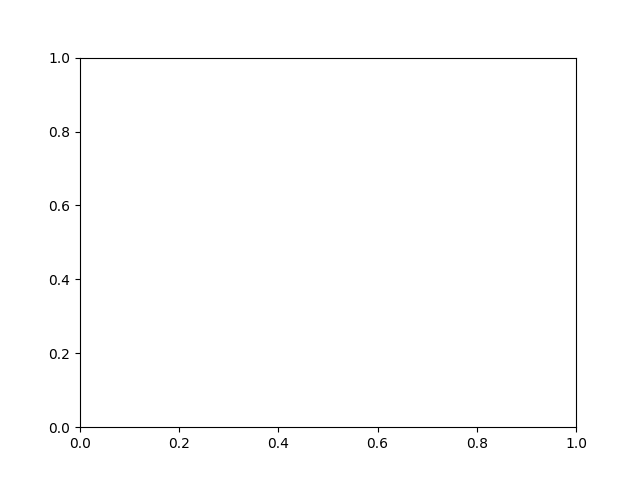

NameError: name 'trace' is not defined

In [5]:
fig0, ax0 = plt.subplots()
ax0.plot(trace.history['loss'], '-')
ax0.plot(trace.history['val_loss'], '-')
ax0.legend(['train', 'val'], loc='upper left')
ax0.set_xlabel('iteration')
ax0.set_ylabel('loss')

In [6]:
# estimates = model.predict(x_train[0:100:16])
# print(estimates)
# print(y_train[0:100:16])
estimates = model.predict(x_test[:10]) #* 10
print("estimated translation x y z")
print(estimates)
print("actual translation x y z")
print(y_test[:10])

err = y_test[:10] - estimates
# err = y_train[0:100:16] - estimates

print("\n Error \n",err)

print(tf.math.reduce_mean(tf.math.reduce_sum(err, axis = 1)))




estimated translation x y z
[[-0.59107405  0.39184257 -0.09181679]
 [ 0.22845386 -0.21157159 -0.04951385]
 [-2.2680507   1.427685    0.03755088]
 [ 0.6058299   1.8168693   0.01145696]
 [ 1.7300794   1.2172884  -0.06031874]
 [-2.6875787   0.63983047  0.09634196]
 [-0.6238022  -0.05288991 -0.15105379]
 [-0.7778395  -1.01678    -0.13063842]
 [-0.53413653  0.7284797  -0.18316889]
 [ 0.12050951  0.12970905  0.1318966 ]]
actual translation x y z
[[-0.53767616  0.43226847 -0.10343488]
 [ 0.24854778 -0.1771922  -0.04946589]
 [-2.2236557   1.46474469  0.06424494]
 [ 0.65221065  1.89100528  0.0081946 ]
 [ 1.72991061  1.28372049 -0.05821136]
 [-2.69916677  0.67205811  0.11757749]
 [-0.57233495 -0.02096893 -0.1296562 ]
 [-0.76790684 -0.98293072 -0.12999502]
 [-0.49831334  0.71898925 -0.19698909]
 [ 0.12633248  0.1541342   0.1369599 ]]

 Error 
 [[ 5.33978939e-02  4.04258966e-02 -1.16180852e-02]
 [ 2.00939178e-02  3.43793929e-02  4.79556620e-05]
 [ 4.43949699e-02  3.70596647e-02  2.66940594e-02]
 [

<IPython.core.display.Javascript object>


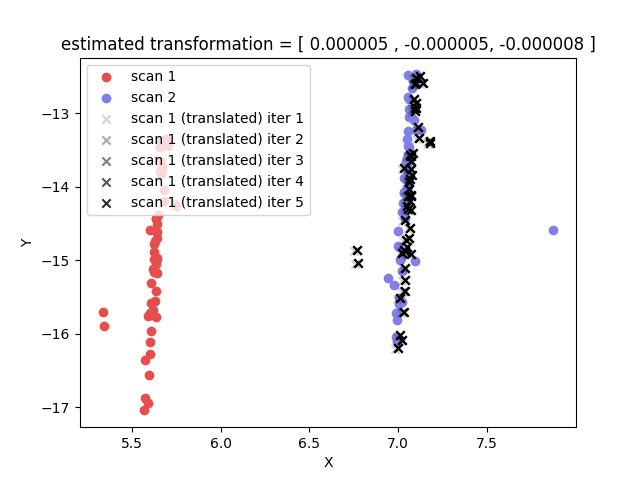

n =  360

 correct soln [ 1.3985486   0.98367727 -0.10407238]

 estiamted soln: [[ 1.4309099   0.85443938 -0.16608529]]

 error from DNN: [[-0.0323613   0.12923789  0.06201291]]

 error in means [-0.03202739  0.1197224  -0.03935493]


In [12]:
#visualize results of network on test data
#2d plots (x and y only)
fig1, ax1 = plt.subplots()
n = int(np.floor(500*np.random.rand()))
# n = 8 #sample number (from x_test)

print("n = ", n)

# print(tf.shape(x_test))
# c1 = np.array([x_test[n,:points_per_sample,0].numpy(), x_test[n,:points_per_sample,1].numpy(), x_test[n,:points_per_sample,2].numpy()])
# c2 = np.array([x_test[n,points_per_sample:,0].numpy(), x_test[n,points_per_sample:,1].numpy(), x_test[n,points_per_sample:,2].numpy()])
c1 = np.array([x_test[n,:points_per_sample,0], x_test[n,:points_per_sample,1], x_test[n,:points_per_sample,2]])
c2 = np.array([x_test[n,points_per_sample:,0], x_test[n,points_per_sample:,1], x_test[n,points_per_sample:,2]])
ax1.scatter(c1[0,:], c1[1,:], color = [0.9, 0.3, 0.3], label = 'scan 1')
ax1.scatter(c2[0,:], c2[1,:], color = [0.5, 0.5, 0.9], label = 'scan 2')


inputs = x_test[n][None,:]
runlen = 5
corr_sum = np.zeros([1,3]) #init var to store correction contributions
for i in range(runlen):
    correction = model.predict(inputs)[0] #show what the network thinks
#     correction = correction*0.1
#     correction = y_test[n] #show actual solution
    corr_sum += correction
#     print(correction)
    c1 = np.array([c1[0,:] + correction[0], c1[1,:] + correction[1], c1[2,:] + correction[2]])
    inputs = np.append(c1, c2, axis = 1).T[None,:,:]
    moved = ax1.scatter(c1[0,:], c1[1,:], marker = 'x', color = [0., 0., 0., (i+1)/(runlen+1)],
                        label = 'scan 1 (translated) iter %i' %(i+1))

# moved = ax1.scatter(c1[0,:], c1[1,:], marker = 'x', color = [0.9, 0.3, 0.3, (i+2)/(runlen+2)],
#                         label = 'scan 1 (translated)')

ax1.set_title("estimated transformation = [ %f , %f, %f ]" %(correction[0], correction[1], correction[2]))
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
ax1.legend(loc = 'best')

print("\n correct soln", y_test[n])
# print("\n y_test", y_test[n]*0.1)
print("\n estiamted soln:", corr_sum)
print("\n error from DNN:", y_test[n] - corr_sum)
print("\n error in means",  y_test[n] + (np.mean(x_test[n,:points_per_sample], axis = 0) - 
      np.mean(x_test[n,points_per_sample:], axis = 0)))

In [13]:
#use Vedo to plot inital and transformed point clouds in 3D 
from vedo import *
from ipyvtklink.viewer import ViewInteractiveWidget

plt1 = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True)
disp = []

#draw scan1 
# disp.append(Points(x_test[n,:points_per_sample].numpy(), c = 'green', r = 5))
disp.append(Points(x_test[n,:points_per_sample], c = 'green', r = 5))

#draw initial scan2
# disp.append(Points(x_test[n,points_per_sample:].numpy(), c = 'red', r = 5))
disp.append(Points(x_test[n,points_per_sample:], c = 'red', r = 5))

#draw transformed scan2
disp.append(Points(c1, c = 'blue', r = 5))

plt1.show(disp, "Network Performance Test")
ViewInteractiveWidget(plt1.window)



ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

In [ ]:
#save network
# model.save("ffnet10k25.kmod")
# model.save("Net.kmod")
# model.save("PIPEnet10.kmod")
# model.save("KITTInet.kmod")
# model.save("FordNet.kmod")
# model.save("FordNetV2.kmod")
# model.save("FULL_KITTInet4500.kmod")


#load network
# model = tf.keras.models.load_model("Net.kmod")
# model = tf.keras.models.load_model("FordNet.kmod")
# model = tf.keras.models.load_model("PIPEnet10.kmod")
# model = tf.keras.models.load_model("KITTInet.kmod")
# model = tf.keras.models.load_model("FORDNetV3.kmod")

In [ ]:
#test random shuffle layer to enforce training on unordered data
#GOAL: randomize order of each sample in batch SEPRATELY 
#      (i.e. don't have same order for all elements of batch)

test = tf.constant([[1., 3., 4.], [2., 3., 5.], [6., 6., 6.], [0., 0., 0.]])#[None, :, :]
test = tf.Variable([test, 2*test])
print(test)

test = tf.transpose(test, [1,0,2])
test = tf.random.shuffle(test)
test = tf.transpose(test, [1,0,2])
print(test)

### Top scores:

#### 1k dataset
8.23 MSE with no parallelization (vel = [5, 5, 5])

4.2 MSE (vel = [5, 5, 0.01])

3.9 MSE - 50 sample points from each scan

3.34- maxpool on first/ second half, conv after


#### 10k dataset

2.4 MSE 50 samples

1.05 MSE 25 samples -ffNet10k25.kmod

### KITTI drive 005, 100 frames

0.145 - Permnet

0.0895 -PCRnet

0.0520 KITTInet (5/20)

### KITTI drive 005, 150 frames, 50 sample points
0.759 pipeNET

### Ford Campus Drive 01 (200 frame sample)
0.073 - NET, 200 frames, with ground plane

### KITTI Full 00 400 frames, with ground plane
0.0752 net

### KITTI Full 00 400 frames, no ground plane
0.0756

### KITTI Full 00 4500 frames, with ground plane
0.0736 net


### Notes
From PointNet: Small rotations and gaussian noise can successfully augment models to increase training dataset

Need to figure out a way to achieve permutation invariance
Try transformer network i.e. "Attention is all you need"
https://ai.googleblog.com/2021/11/permutation-invariant-neural-networks.html

Can potentially use reflectance as 4th dimension(?)

### Find average error in mean point locations when ground truth solution is applied
Test for indexing when geterating training data using Ford dataset - this error should be minimal when we are correctly indexing gt

In [ ]:
d1 = np.loadtxt('training_data/ICET_Ford_scan1.txt') #available in repo
d2 = np.loadtxt('training_data/ICET_Ford_scan2.txt')
truth = np.loadtxt('training_data/ICET_Ford_ground_truth.txt')

points_per_sample = 50 #25 #50  #num pts per scan - defined in MatLab script
s1 = tf.reshape(tf.convert_to_tensor(d1), [-1, points_per_sample, 3])
s2 = tf.reshape(tf.convert_to_tensor(d2), [-1, points_per_sample, 3])
truth = tf.convert_to_tensor(truth)

In [ ]:
print(tf.shape(s1))
mu1 = tf.math.reduce_mean(s1, axis = 1)
mu2 = tf.math.reduce_mean(s2, axis = 1)
# print("\n mu1", mu1)
# print("\n mu2", mu2)
centers_error = mu1 - mu2 + truth 
# print("\n centers_error", centers_error)

#get mean absolute centers error across all voxels
# mace = tf.math.reduce_mean(abs(centers_error), axis = 0) #absolute error
mace = tf.math.reduce_mean(centers_error, axis = 0)
print("\n mace", mace)